# Is there a Pet waiting?
In this notebook I will use transfer learning to train a classifier
which classifies if there is a pet present on a cctv camera.
RESNET 18 will be use for this project

In [7]:
import torch
from torchvision.models import resnet18
from torchvision.datasets import ImageFolder
import torchvision.transforms as tfs
from torchvision.utils import make_grid
import torch.nn as nn
from torchinfo import summary
from torch.utils.data import random_split, DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Create transforms

# general_transforms = tfs.Compose([
#     tfs.Resize((224,224)),
#     tfs.ToTensor()
#     ])

train_transforms = tfs.Compose([
    tfs.Resize((224,224)),
    tfs.ToTensor(),
    tfs.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    tfs.RandomPosterize(bits=2,p=0.25),
    tfs.RandomAdjustSharpness(sharpness_factor=2,p=0.5),
    tfs.RandomAutocontrast()
])

test_val_transforms = tfs.Compose([
    tfs.Resize((224,224)),
    tfs.ToTensor(),
    tfs.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

#Load the dataset and create dataloaders
all_datasets = ImageFolder("./data_cleaned")
dataset_len = len(all_datasets)
train, validation, test = random_split(all_datasets, [int(dataset_len*0.75),0,int(dataset_len*0.25+1)])
print(f"Overall dataset size: {dataset_len}, train: {len(train)}, validation: {len(validation)}, test: {len(test)}")

train.dataset.transform = train_transforms
validation.dataset.transform = test_val_transforms
test.dataset.transform = test_val_transforms

batches = [4,8,16,32,64]
lrs = [0.1,0.05,0.025,0.01,0.005,0.001,0.0001]
repetitions = 2

perc_accuracy = np.zeros((len(batches),len(lrs)))
avg_losses = np.zeros((len(batches),len(lrs)))

Overall dataset size: 381, train: 285, validation: 0, test: 96


In [8]:


for a,batch_size in enumerate(batches): 
    for b,lr_size in enumerate(lrs):
        running_avg_loss = None
        running_avg_correct = None
        for rep in range(repetitions):
            # Define hyperparameters

            BATCH_SIZE = batch_size
            LR = lr_size
            EPOCHS = 20
            device = "cuda"

            # Prepare the model for transfer learning
            model = resnet18(pretrained=True)

            for parameters in model.parameters():
                parameters.requires_grad = False

            last_layer_shape = model.fc.in_features

            model.fc = nn.Linear(last_layer_shape, 2)
            model = model.to(device)


            train_loader = DataLoader(train,shuffle=True, batch_size=BATCH_SIZE)
            validation_loader = DataLoader(validation, batch_size=BATCH_SIZE)
            test_loader = DataLoader(test, batch_size=BATCH_SIZE)

            # Define the Loss function and optimizer
            optimizer = torch.optim.SGD(model.parameters(),lr= LR)
            loss_fn = torch.nn.CrossEntropyLoss()


            train_losses = []
            epoch_train_losses = []
            train_correct_epoch = []
            train_correct_epoch_perc = []


            validation_losses = []
            epoch_val_losses = []

            for epoch in range(EPOCHS):
                running_epoch_loss = None
                running_correct = 0
                model.train()
                for batch in train_loader:
                    x,y = batch
                    x = x.to(device)
                    y = y.to(device)
                    
                    # 1. Get the prediction
                    pred = model(x)
                    
                    # 2. Compute the loss
                    loss = loss_fn(pred,y)
                    
                    # 3. Zerout the gradients
                    optimizer.zero_grad()
                    
                    # 4. Compute new gradients and acumulate them
                    loss.backward()
                    
                    # 5. Perform a optimization step
                    optimizer.step()
                    
                    # 3. Get num correct
                    _correct = (torch.argmax(pred, dim=1) == y).sum()
                    running_correct += _correct.detach()
                    
                    # Log metrics
                    loss_detached = loss.detach()
                    
                    train_losses.append(loss_detached.cpu())
                    
                    if running_epoch_loss is not None:
                        running_epoch_loss = (running_epoch_loss + loss_detached) / 2.0
                    else:
                        running_epoch_loss = loss_detached
                        
                    # print(f"Training | EPOCH: {epoch+1} | Average Loss: {running_epoch_loss:.4f} | Current Mini-batch loss: {loss_detached:.4f}")
                
                epoch_train_losses.append(running_epoch_loss)
                train_correct_epoch.append(running_correct.cpu())
                train_correct_epoch_perc.append(running_correct.cpu()/len(train))
                
                running_epoch_loss = None
                model.eval()
                for batch in validation_loader:
                    x,y = batch
                    x = x.to(device)
                    y = y.to(device)
                    
                    # 1. Get the prediction
                    with torch.no_grad():
                        pred = model(x)
                        
                        # 2. Compute the loss
                        loss = loss_fn(pred,y)
                    
                    # Log metrics
                    loss_detached = loss.detach()
                    
                    validation_losses.append(loss_detached.cpu())
                    
                    if running_epoch_loss is not None:
                        running_epoch_loss = (running_epoch_loss + loss_detached) / 2.0
                    else:
                        running_epoch_loss = loss_detached
                        
                    # print(f"Validation | EPOCH: {epoch+1} | Average Loss: {running_epoch_loss:.4f} | Current Mini-batch loss: {loss_detached:.4f}")
                    
                epoch_val_losses.append(running_epoch_loss)   
                        

            test_losses = []
            avg_loss = None

            correct = 0

            model.eval()

            for batch in test_loader:
                x,y = batch
                x = x.to(device)
                y = y.to(device)
                
                # 1. Get the prediction
                with torch.no_grad():
                    pred = model(x)
                
                    # 2. Compute the loss
                    loss = loss_fn(pred,y)
                
                # 3. Get num correct
                _correct = (torch.argmax(pred, dim=1) == y).sum()
                correct += _correct.detach()
                # Log metrics
                loss_detached = loss.detach()
                
                test_losses.append(loss_detached.cpu())
                
                if avg_loss is not None:
                    avg_loss = (avg_loss + loss_detached) / 2.0
                else:
                    avg_loss = loss_detached
                    
            last_average_loss = epoch_train_losses[-1].item()
            
            if running_avg_loss is not None:
                running_avg_loss = (running_avg_loss+avg_loss)/2.0
            else:
                running_avg_loss = avg_loss
                
            if running_avg_correct is not None:
                running_avg_correct = (running_avg_correct+correct)/2.0
            else:
                running_avg_correct = correct
                
        print(f"Testing B:{batch_size} LR: {lr_size} | Average Loss: {running_avg_loss} | Correct {running_avg_correct}/{len(test)} or {(running_avg_correct/len(test))*100}%")
            
        perc_accuracy[a][b] = ((running_avg_correct/len(test))*100)
        avg_losses[a][b] = (running_avg_loss)

        # print(f"Difference in Train loss and Test loss: {abs(avg_loss -last_average_loss)}")


Testing B:4 LR: 0.1 | Average Loss: 21.105649948120117 | Correct 61.5/96 or 64.0625%
Testing B:4 LR: 0.05 | Average Loss: 7.510409832000732 | Correct 59.0/96 or 61.458335876464844%
Testing B:4 LR: 0.025 | Average Loss: 3.8812596797943115 | Correct 67.5/96 or 70.3125%
Testing B:4 LR: 0.01 | Average Loss: 0.1347980946302414 | Correct 86.5/96 or 90.10417175292969%
Testing B:4 LR: 0.005 | Average Loss: 0.5024362206459045 | Correct 83.0/96 or 86.45833587646484%
Testing B:4 LR: 0.001 | Average Loss: 0.46053290367126465 | Correct 87.5/96 or 91.14583587646484%
Testing B:4 LR: 0.0001 | Average Loss: 0.5307808518409729 | Correct 77.5/96 or 80.72917175292969%
Testing B:8 LR: 0.1 | Average Loss: 1.4222126007080078 | Correct 90.5/96 or 94.27083587646484%
Testing B:8 LR: 0.05 | Average Loss: 0.40029698610305786 | Correct 83.0/96 or 86.45833587646484%
Testing B:8 LR: 0.025 | Average Loss: 0.1699320524930954 | Correct 92.0/96 or 95.83333587646484%
Testing B:8 LR: 0.01 | Average Loss: 0.184507071971893

In [34]:
# Check the model is correctly initialized
# summary(model,input_size=(1,3,224,224))

In [10]:
perc_accuracy

array([[64.0625    , 61.45833588, 70.3125    , 90.10417175, 86.45833588,
        91.14583588, 80.72917175],
       [94.27083588, 86.45833588, 95.83333588, 94.27083588, 92.70833588,
        91.14583588, 73.4375    ],
       [95.3125    , 95.3125    , 93.22917175, 83.85417175, 94.79167175,
        91.14583588, 71.35417175],
       [71.875     , 88.02083588, 85.9375    , 92.70833588, 91.66667175,
        90.625     , 65.10417175],
       [92.70833588, 82.8125    , 91.66667175, 91.14583588, 92.1875    ,
        82.29167175, 63.02083588]])

In [15]:
import pandas as pd
_out = pd.DataFrame(perc_accuracy,columns=lrs,index=batches)

_out.to_excel("results2.xlsx")

In [37]:
# Inspect the dataset
# import matplotlib.pyplot as plt


# data = next(iter(train_loader))[0]
# data = make_grid(data)


# plt.imshow(data.permute(1,2,0).numpy())
    
# plt.show()

## Training and Validation loops

Training | EPOCH: 1 | Average Loss: 0.6892 | Current Mini-batch loss: 0.6892
Training | EPOCH: 1 | Average Loss: 0.6937 | Current Mini-batch loss: 0.6982
Training | EPOCH: 1 | Average Loss: 0.6697 | Current Mini-batch loss: 0.6456
Training | EPOCH: 1 | Average Loss: 0.6210 | Current Mini-batch loss: 0.5724
Training | EPOCH: 1 | Average Loss: 0.6279 | Current Mini-batch loss: 0.6349
Validation | EPOCH: 1 | Average Loss: 0.6339 | Current Mini-batch loss: 0.6339
Training | EPOCH: 2 | Average Loss: 0.6084 | Current Mini-batch loss: 0.6084
Training | EPOCH: 2 | Average Loss: 0.5822 | Current Mini-batch loss: 0.5561
Training | EPOCH: 2 | Average Loss: 0.5777 | Current Mini-batch loss: 0.5732
Training | EPOCH: 2 | Average Loss: 0.5575 | Current Mini-batch loss: 0.5373
Training | EPOCH: 2 | Average Loss: 0.5562 | Current Mini-batch loss: 0.5548
Validation | EPOCH: 2 | Average Loss: 0.5730 | Current Mini-batch loss: 0.5730
Training | EPOCH: 3 | Average Loss: 0.5118 | Current Mini-batch loss: 0.

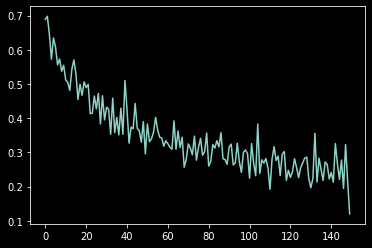

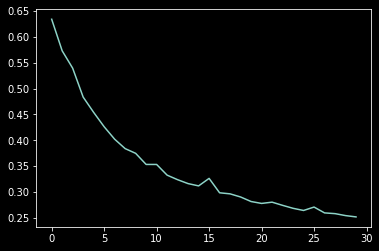

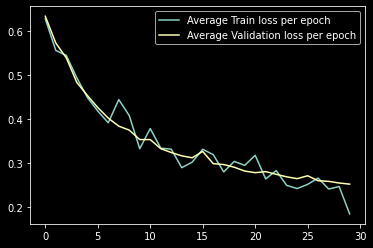

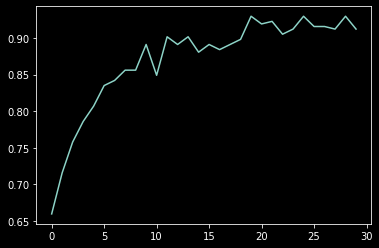

In [40]:
# Visualize the metrics
plt.plot(train_losses)
plt.show()  

plt.plot(validation_losses)
plt.show()

plt.plot([_.cpu() for _ in epoch_train_losses],label="Average Train loss per epoch")
plt.plot([_.cpu() for _ in epoch_val_losses],label="Average Validation loss per epoch")
plt.legend()
plt.show()

plt.plot(train_correct_epoch_perc)

## Test loop

Testing | Average Loss: 0.3467 | Current Mini-batch loss: 0.3467


Testing | Average Loss: 0.3467334508895874 | Correct 41/49 or 83.6734619140625%
Difference in Train loss and Test loss: 0.1625814586877823


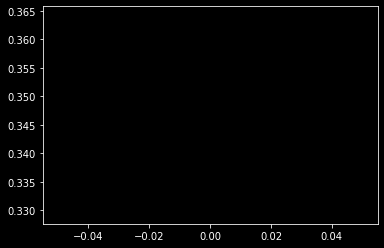

In [43]:
plt.plot(test_losses)
plt.show()

In [44]:
#torch.save(model,"./models/model4SGD_97-13_20epochs_001LR_256BS.pth")